# Introduction

In this notebook, we'll train a model to predict the sentiment of a tweet. Then we will use it against real tweets in real-time

# Install Dependencies

In [28]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

# twitter api
import tweepy
from tweepy import OAuthHandler

# Importing Dataset

The dataset being used is the "sentiment140" dataset. It contains 1,600,000 tweets extracted using the Twitter API. The tweets have been annotated (0 = Negative, 4 = Positive) and they can be used to detect sentiment.<br>

**The training data isn't perfectly categorised as it has been created by tagging the text according to the emoji present. So, any model built using this dataset may have lower than expected accuracy, since the dataset isn't perfectly categorised.**

<br>The dataset contains the following 6 fields:<br>
- sentiment: the polarity of the tweet (0 = negative, 4 = positive)
- ids: The id of the tweet
- date: the date of the tweet
- flag: The query. If there is no query, then this value is NO_QUERY.
- user: the user that tweeted
- text: the text of the tweet

We will need only the sentiment and text fields, others will be removed.<br>

Moreover, we're changing the sentiment field so that it has new values to reflect the sentiment. (0 = Negative, 1 = Positive)

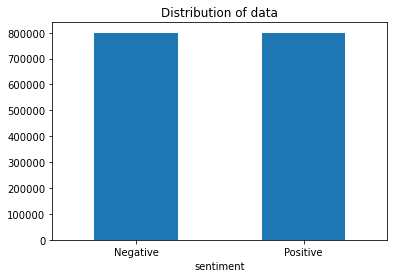

In [29]:
# Importing the dataset
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('D:/SA/training.1600000.processed.noemoticon.csv',
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

# Removing the unnecessary columns.
dataset = dataset[['sentiment','text']]

# Replacing the values to ease understanding.
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

# Plotting the distribution for dataset.
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data', legend=False)

ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data in lists.
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

# Text Preprocessing

The Preprocessing steps taken are:<br>

- **Lower Casing:**<br>Each text is converted to lowercase.
- **Replacing URLs:**<br>Links starting with "http" or "https" or "www" are replaced by "URL".
- **Replacing Emojis:**<br>Replace emojis by using a pre-defined dictionary containing emojis along with their meaning. (eg: ":)" to "EMOJIsmile")
- **Replacing Usernames:**<br>Replace @Usernames with word "USER". (eg: "@Ibrahim" to "USER")
- **Removing Non-Alphabets:**<br>Replacing characters except Digits and Alphabets with a space.
- **Removing Consecutive letters:**<br>3 or more consecutive letters are replaced by 2 letters. (eg: "Heyyyy" to "Heyy")
- **Removing Short Words:**<br>Words with length less than 2 are removed.
- **Removing Stopwords:**<br>Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored  without sacrificing the meaning of the sentence. (eg: "the", "he", "have")
- **Lemmatizing:**<br>Lemmatization is the process of converting a word to its base form. (e.g: “Great” to “Good”)

In [30]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [31]:
def preprocess(textdata):
    processedText = []
    
    # Create the Lemmatizer
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [32]:
import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 99 seconds


# Data Analysis
We'll plot Word Clouds for Positive and Negative tweets to see which words occur the most.

**WordCloud for Negative Tweets**

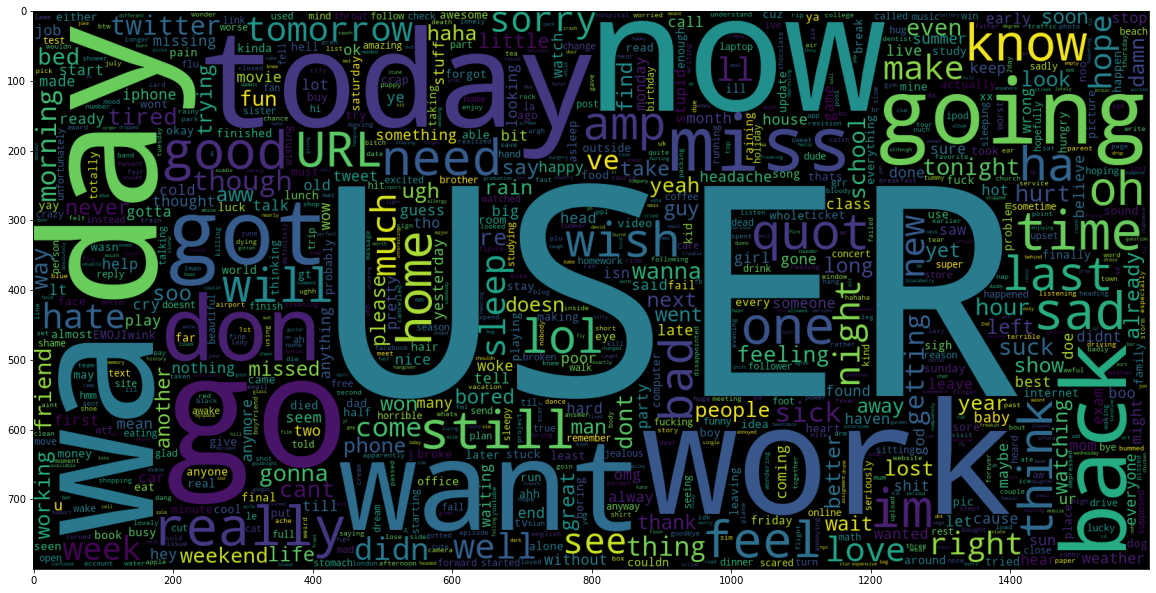

In [33]:
data_neg = processedtext[:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

**WordCloud for Positive Tweets**

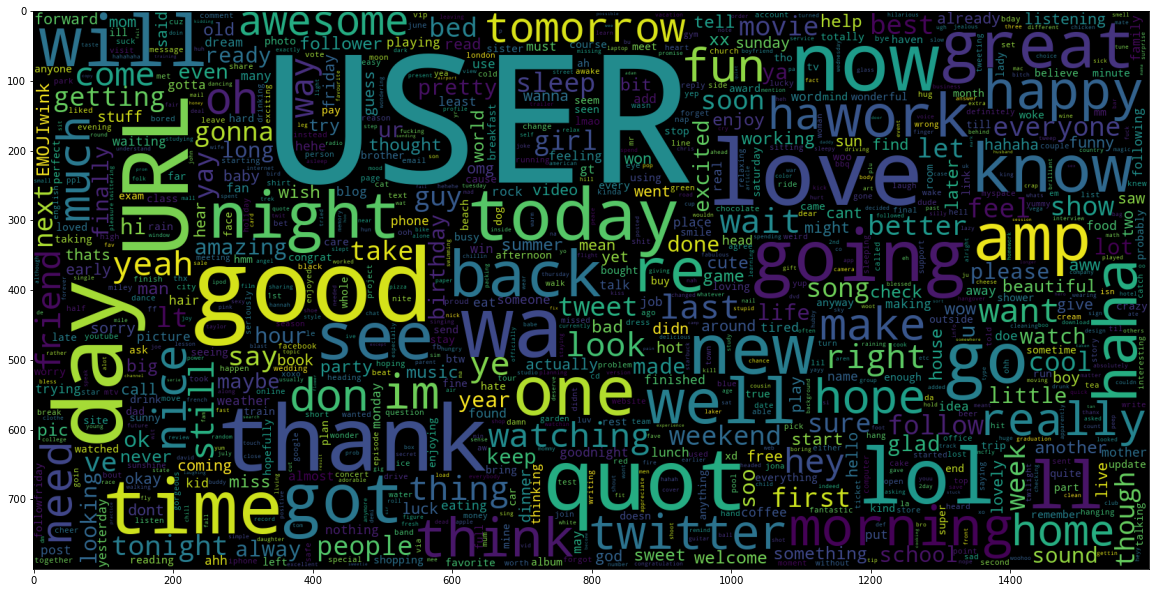

In [34]:
data_pos = processedtext[800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

# Data Splitting

- Training Data: 95%
- Test Data: 5%


In [35]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.05, random_state = 0)
print(f'Data Split done.')

Data Split done.


# Feature Extraction using TF-IDF
TF-IDF indicates what the importance of the word is in order to understand the document or dataset.<br>

TF-IDF Vectoriser converts a collection of raw documents to a matrix of TF-IDF features. The Vectoriser is usually trained on only the X_train dataset.


In [36]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.
No. of feature_words:  500000


In [37]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


# Train and Evaluate Logistic Regression

In [38]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)

LogisticRegression(C=2, max_iter=1000, n_jobs=-1)

In [39]:
y_pred = LRmodel.predict(X_test)
print("Classification Report:\n") 
print(classification_report(y_test, y_pred))
print("\n\nConfusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.82      0.83     39989
           1       0.82      0.84      0.83     40011

    accuracy                           0.83     80000
   macro avg       0.83      0.83      0.83     80000
weighted avg       0.83      0.83      0.83     80000



Confusion Matrix:

[[32745  7244]
 [ 6481 33530]]


# Saving the Model

In [40]:
file = open('vectoriser-ngram-(1,2).pickle','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('Sentiment-LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

# Using the Model
To use the model for Sentiment Prediction we need to import the Vectoriser and LR Model using Pickle.<br>

The vectoriser can be used to transform data to matrix of TF-IDF Features. While the model can be used to predict the sentiment of the transformed Data. The text whose sentiment has to be predicted however must be preprocessed.

In [42]:
# Load Model Function 
def load_models(): 
    # Load the vectoriser.
    file = open('vectoriser-ngram-(1,2).pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()
    
    # Load the LR Model.
    file = open('Sentiment-LR.pickle', 'rb')
    LRmodel = pickle.load(file)
    file.close()
    
    return vectoriser, LRmodel

# Predict Function
def predict(vectoriser, model, text):
    # Predict the sentiment
    textdata = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)
    
    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df

if __name__=="__main__":
    # Loading the models.
    vectoriser, LRmodel = load_models()
    
    # Text to classify should be in a list.
    text = ["I hate twitter",
            "May the Force be with you.",
            "Mr. Stark, I don't feel so good"]
    
    df = predict(vectoriser, LRmodel, text)
    print(df.head())

                              text sentiment
0                   I hate twitter  Negative
1       May the Force be with you.  Positive
2  Mr. Stark, I don't feel so good  Negative


# Real-Time Sentiment Analysis
We will use the model to predict the sentiment of real tweets fetched from Bill Gates Twitter account

**Set Twitter API Credentials**

In [43]:
consumer_key='Y8MBaJftuD6hnIh9USLAgrreq'
consumer_secret='haYlS4fBl5MSLyPf22xt5bp9nJa7bvPnoSqkuweNGzXL2eIoUA'
access_token ='1432989717289709570-sMUd928DJ20Kbok95erdJrakbxVtCG'
access_secret='YoC2uVImYIx9bsZb524lwF9bsiNeaS09Hxu1UveC2mV1j'

**Create the API**

In [44]:
# Create the authentication object
authenticate = tweepy.OAuthHandler(consumer_key, consumer_secret)

# Set the access token and access token secret
authenticate.set_access_token(access_token, access_secret)

# Create the API object
api = tweepy.API(authenticate, wait_on_rate_limit = True)

**Extract and view Tweets**

In [45]:
# Extract 100 tweets from BillGates Twitter account
posts = api.user_timeline(screen_name = 'BillGates', count = 30, lang = 'en', tweet_mode = 'extended')

# Print the last 5 tweets
print("Latest Tweets from Bill Gates: \n")

i = 1
for tweet in posts[0:5]:
    print(str(i) + ') ' + tweet.full_text + '\n')
    i+=1

Latest Tweets from Bill Gates: 

1) But the fact that we can point to positive signs amid a once-in-a-generation global pandemic is extraordinary. With one hand tied behind their backs, countless individuals, organizations, and countries went above and beyond. https://t.co/InzRGXGtyc

2) Of course, the full extent of the pandemic’s impact on the SDGs will take years to fully understand, as more and better data becomes available. And this data doesn’t diminish the very real suffering the pandemic has caused for people everywhere—far from it.

3) Initial projections about the pandemic’s impact on the fight against malaria were dire. But that projection spurred many countries to action to ensure that bed nets were distributed and that testing and antimalarial drugs remained available.

4) When the pandemic hit, many feared the worst when it came to maintaining progress on fighting other diseases. But all over the world people stepped up to avert the worst-case scenarios. One example is ma

**Create a list of tweets**

In [56]:
text = [tweet.full_text for tweet in posts]

**Preprocess Tweets**

In [57]:
text = preprocess(text)

**Predict the sentiments**

In [58]:
df2 = predict(vectoriser, LRmodel, text)
print(df2)

                                                 text sentiment
0   but the fact that we can point to positive sig...  Positive
1   of course the full extent of the pandemic impa...  Negative
2   initial projection about the pandemic impact o...  Negative
3   when the pandemic hit many feared the worst wh...  Negative
4   where you live shouldn determine whether or no...  Positive
5   even amid the devastation of the covid 19 pand...  Positive
6   this news is not surprising to many of u who w...  Negative
7   thinking today about the frontline hero who ri...  Positive
8   rt USER the 2021 goalkeeper report is out next...  Positive
9   how do we use technology and innovation to sol...  Positive
10  the world need many breakthrough to get from 5...  Positive
11  found the book to be valuable on number of lev...  Positive
12  the first time met david sengeh wa blown away ...  Positive
13  africa success against wild polio last year is...  Positive
14  none of u would be where we are toda